# Modeling

This step consists in trying to find the best model which can predict our target value (default credit payment the following month). 
As we have seen during our EDA, we still need to do some data engineering in order to deal with categorical features and rescale the 
numerical features. Once the data engineering is done, we will take the following pragmatic approach :
1. Select list of known classification models
* Run a baseline model for each of our pre-selected models
* Pick the top models base on a specific score (recall score / f1 score in our case)
* Tune the hyper-parameters of the top models and watch score increase

So below is the list of pre-selected classification models :

* Logistic Regression
* Decision Tree
* Random Forest
* AdaBoost
* K Nearest Neighbors
* XGBoost
* SVC (Support Vector Classification)

In order to compare their performances, we need to define a which scoring metrics we are going to use. As we try to find out if
the credit payment status (paid or not paid the following month), it is important to catch as much as possible the ones that are 
positive (not paid => target value = 1). Or in other words, we will try to minimise the **False Positive** classifications (paid status predicted when the actual status is not paid). This is exactly the **Recall score** definition. Also, we want to keep our accuracy high
**True Negative + True Positive** observations. See below a visual definition 

![Precision Recall Definition](pictures/700px-Precisionrecall.svg.png)

**Recall, Precision and F1-score Formulas**:

$Recall = \frac{TP}{TP + FN}$

$Precision = \frac{TP}{TP + FP}$

$F1 = 2 * \frac{Recall * Precision}{Recall + Precision}$


## Preprocessing features

In the next step we are applying what as been seen during the EDA step : Converting categorical features and Scaling numerical features.

In order to make our process repeteable, we will introduce SKlearn Pipeline to streamline our preprocessing along with the modeling step.

In [6]:
# Load utility librairies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from utils import print_metrics, print_confusion_matrix
from sklearn.metrics import classification_report, recall_score

# Load pre-selected models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

%matplotlib inline
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Loading data

In [7]:
credits = pd.read_excel('credit-cards.xls', header=1)
credits.drop(columns=['ID'], inplace=True)  # Remove ID column

#### Building Pipeline feature engineering step

In [8]:
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

# Class Columns used to apply features transformation
class Columns(BaseEstimator, TransformerMixin):
    def __init__(self, names=None):
        self.names = names

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X):
        return X[self.names]

# List of numerical features
numeric = [
    'LIMIT_BAL',
    'AGE',
    'BILL_AMT1',
    'BILL_AMT2',
    'BILL_AMT3',
    'BILL_AMT4',
    'BILL_AMT5',
    'BILL_AMT6',
    'PAY_0',
    'PAY_2',
    'PAY_3',
    'PAY_4',
    'PAY_5',
    'PAY_6',
    'PAY_AMT1',
    'PAY_AMT2',
    'PAY_AMT3',
    'PAY_AMT4',
    'PAY_AMT5',
    'PAY_AMT6',
]

# List of categorical features
categorical = ['SEX', 'EDUCATION', 'MARRIAGE']

# Build feature engineering pipeline step
features = FeatureUnion([
        ('numeric', make_pipeline(Columns(names=numeric),StandardScaler())),
        ('categorical', make_pipeline(Columns(names=categorical),OneHotEncoder(sparse=False)))
    ])


## Building Pipeline Modeling Step

#### Getting our train/test datasets

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
X = credits.iloc[:, :-1]
y = credits.iloc[:,-1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=123)

In [11]:
# Fix issue with libomp conflicts
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Bellow, we train our pre-selected baseline models on our train dataset and display the scoring output.

Tested Model:  lr
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      7052
           1       0.70      0.25      0.37      1948

   micro avg       0.81      0.81      0.81      9000
   macro avg       0.76      0.61      0.63      9000
weighted avg       0.80      0.81      0.78      9000



Tested Model:  dt_cls
              precision    recall  f1-score   support

           0       0.84      0.81      0.83      7052
           1       0.39      0.43      0.41      1948

   micro avg       0.73      0.73      0.73      9000
   macro avg       0.61      0.62      0.62      9000
weighted avg       0.74      0.73      0.74      9000



Tested Model:  rf_clf
              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7052
           1       0.59      0.33      0.42      1948

   micro avg       0.80      0.80      0.80      9000
   macro avg       0.71      0.63      0.65      9000
weighted

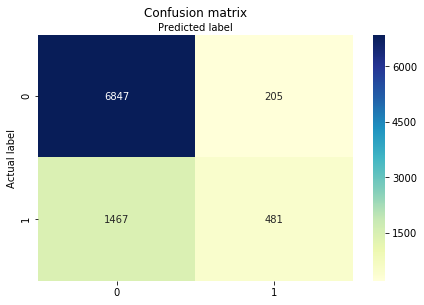

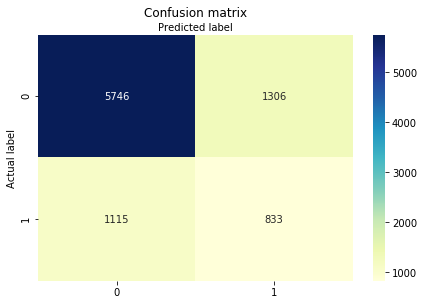

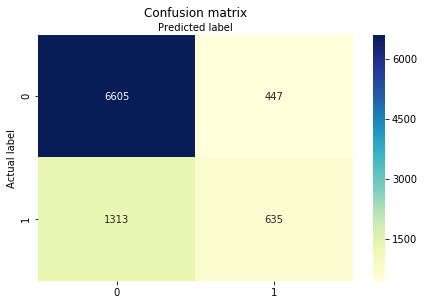

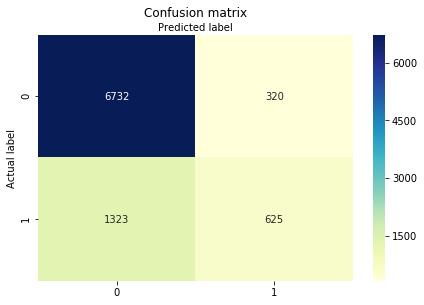

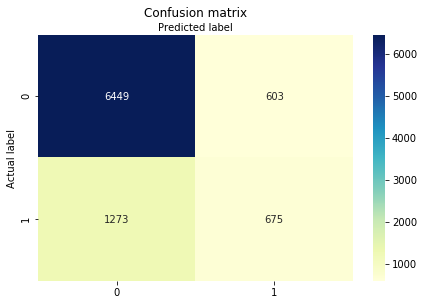

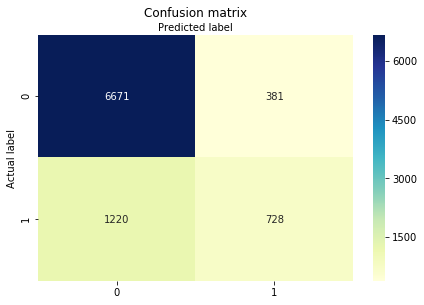

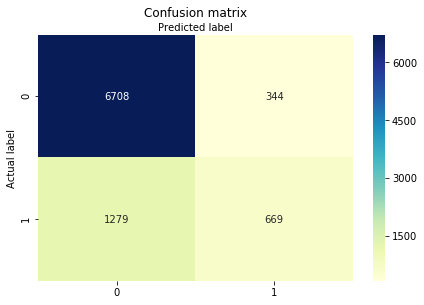

In [12]:
tested_models = {
    'lr': LogisticRegression(),
    'dt_cls': DecisionTreeClassifier(),
    'rf_clf': RandomForestClassifier(),
    'adaboost_clf': AdaBoostClassifier(),
    'knn_clf': KNeighborsClassifier(),
    'xgb_clf': XGBClassifier(),
    'sv_clf': SVC()
}

for model in tested_models:
    pipe = Pipeline([
        ("features", features),
        ('model', tested_models[model])
    ])

    pipe.fit(X_train, y_train)

    y_hat_test = pipe.predict(X_test)
    
    print('======================')
    print('Tested Model: ', model)
    print('======================')
    print(classification_report(y_test, y_hat_test))
    print_confusion_matrix(y_test, y_hat_test)
    print('\n')
    


**Notes**: As we can see our baseline models performances are not great when looking at recall and f1 scores.
Because our dataset is not equally spit between our target values (paid vs not paid following month) it might
be interresting to train our models on non-imbalance dataset. One technique to do it is to use the SMOTE class
from `imblearn` librairie.

In [13]:
# Deal with imbalance using SMOTE
from imblearn.over_sampling import SMOTE

# Smote train dataset using a 50-50 split
smote = SMOTE(sampling_strategy=1)
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

# Transform resample X_train into DataFrame
X_train_resampled = pd.DataFrame(X_train_resampled)
X_train_resampled.columns = X.columns

Now that we have resample our train dataset we can re-run our baseline training models

Tested Model:  lr
              precision    recall  f1-score   support

           0       0.86      0.71      0.78      7052
           1       0.36      0.58      0.44      1948

   micro avg       0.68      0.68      0.68      9000
   macro avg       0.61      0.65      0.61      9000
weighted avg       0.75      0.68      0.71      9000



Tested Model:  dt_cls
              precision    recall  f1-score   support

           0       0.84      0.74      0.79      7052
           1       0.35      0.50      0.41      1948

   micro avg       0.69      0.69      0.69      9000
   macro avg       0.60      0.62      0.60      9000
weighted avg       0.74      0.69      0.71      9000



Tested Model:  rf_clf
              precision    recall  f1-score   support

           0       0.85      0.86      0.85      7052
           1       0.47      0.45      0.46      1948

   micro avg       0.77      0.77      0.77      9000
   macro avg       0.66      0.66      0.66      9000
weighted

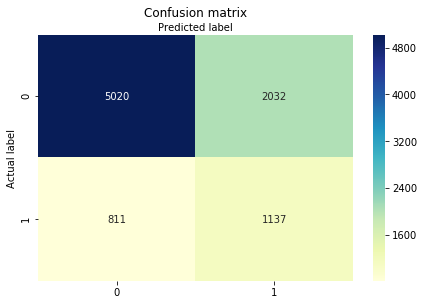

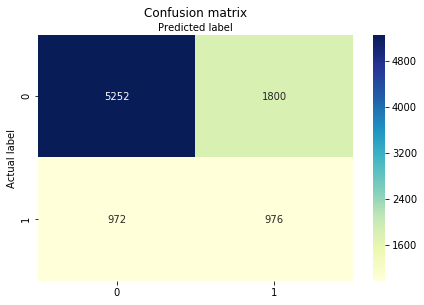

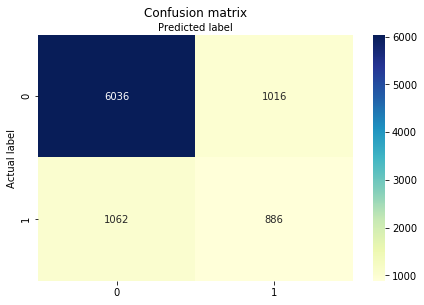

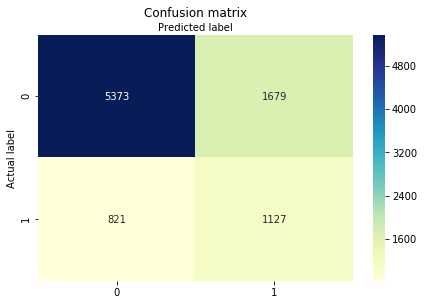

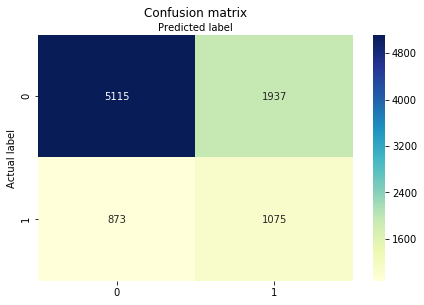

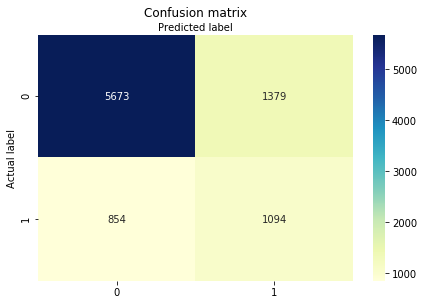

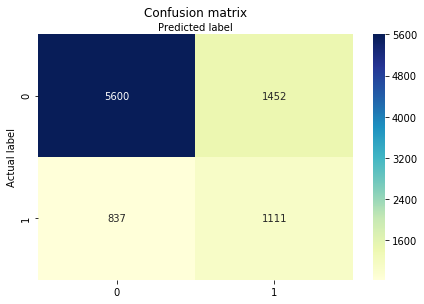

In [14]:
for model in tested_models:
    pipe = Pipeline([
        ('features', features),
        ('model', tested_models[model])
    ])

    pipe.fit(X_train_resampled, y_train_resampled)

    y_hat_test = pipe.predict(X_test)

    print('======================')
    print('Tested Model: ', model)
    print('======================')
    print(classification_report(y_test, y_hat_test))
    print_confusion_matrix(y_test, y_hat_test)
    print('\n')

**Notes**: `recall` an `f1-score` have significantly increase after dealing with our imbalanced dataset. Some 
models like Logistic regression have more than double their `recall` score (from .25 to .58)

Now let's see if dimentionality reduction improves performance. Here we are using `PCA` class to runn the experiment.

Tested Model:  lr
              precision    recall  f1-score   support

           0       0.86      0.71      0.78      7052
           1       0.36      0.58      0.44      1948

   micro avg       0.68      0.68      0.68      9000
   macro avg       0.61      0.65      0.61      9000
weighted avg       0.75      0.68      0.71      9000



Tested Model:  dt_cls
              precision    recall  f1-score   support

           0       0.84      0.70      0.77      7052
           1       0.33      0.52      0.40      1948

   micro avg       0.66      0.66      0.66      9000
   macro avg       0.58      0.61      0.58      9000
weighted avg       0.73      0.66      0.69      9000



Tested Model:  rf_clf
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      7052
           1       0.42      0.47      0.44      1948

   micro avg       0.75      0.75      0.75      9000
   macro avg       0.63      0.64      0.64      9000
weighted

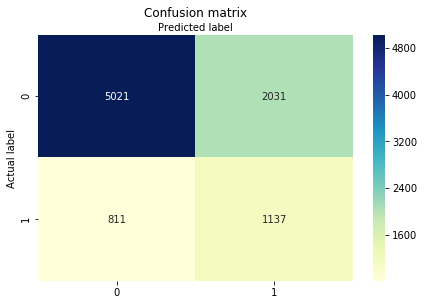

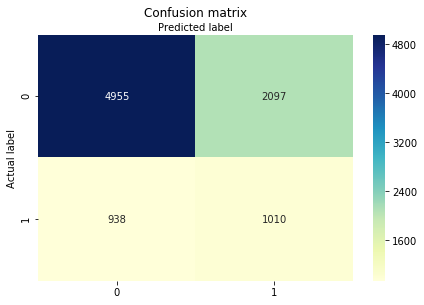

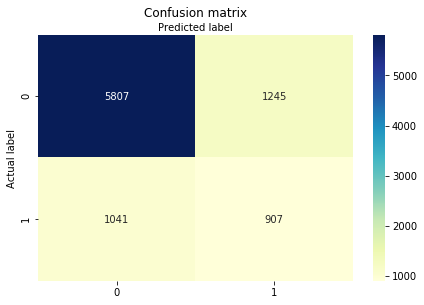

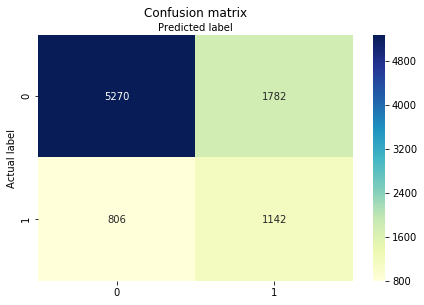

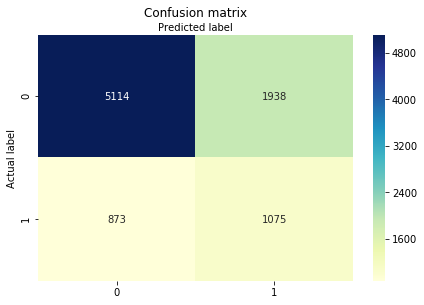

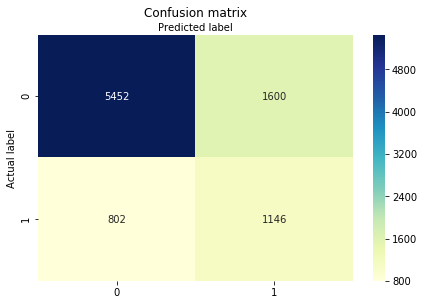

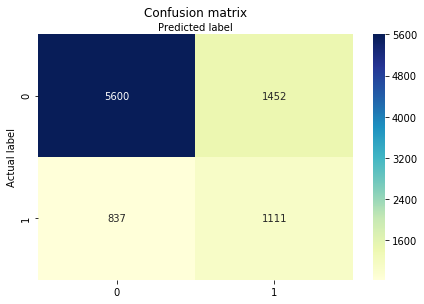

In [15]:
# reducing dimensionality using PCA
from sklearn.decomposition import PCA
for model in tested_models:
    pipe = Pipeline([
        ('features', features),
        ('reduce_dim', PCA()),
        ('model', tested_models[model])
    ])

    pipe.fit(X_train_resampled, y_train_resampled)

    y_hat_test = pipe.predict(X_test)

    print('======================')
    print('Tested Model: ', model)
    print('======================')
    print(classification_report(y_test, y_hat_test))
    print_confusion_matrix(y_test, y_hat_test)
    print('\n')

**Notes**: The performance improvement doesn't look significant. In the following hyper-parameters tuning step, 
we will work exclusively on Logistic Regression and AdaBoost models. Even if the baseline model XGBoost has comparable
performances we won't select it due to computation time performing.

## Hyper-parameters tuning step

In the following steps, we are going to use GridSearchCV class in order to perform our hyper-parameters tuning step.

#### Logistic Regression Model

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.6s finished


{'lr__C': 1.0, 'lr__penalty': 'l2'}
Tested Model:  LogReg
              precision    recall  f1-score   support

           0       0.86      0.71      0.78      7052
           1       0.36      0.58      0.44      1948

   micro avg       0.68      0.68      0.68      9000
   macro avg       0.61      0.65      0.61      9000
weighted avg       0.75      0.68      0.71      9000





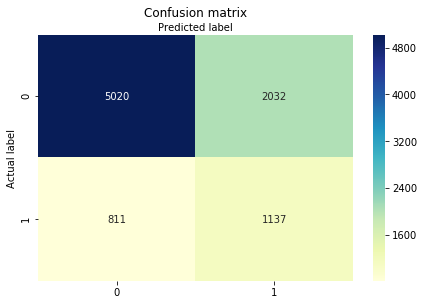

In [16]:
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__penalty': ['l1', 'l2'],
    'lr__C': np.logspace(0, 4, 10)
}

pipe = Pipeline([
    ('features', features),
    ('lr', LogisticRegression())
])

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

clf.fit(X_train_resampled, y_train_resampled)

print(clf.best_params_)
y_hat_test = clf.predict(X_test)

print('======================')
print('Tested Model: ', 'LogReg')
print('======================')
print(classification_report(y_test, y_hat_test))
print_confusion_matrix(y_test, y_hat_test)
print('\n')

**Notes**: We can't see any improvement here after running our hyper-parameter tuning step. The best hyper-parameters are
actually the default ones from `LogisticRegression` class.

#### AdaBoost Model

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   11.3s finished


{'ada__learning_rate': 1.0, 'ada__n_estimators': 23}
Tested Model:  ADABOOST
              precision    recall  f1-score   support

           0       0.87      0.77      0.82      7052
           1       0.41      0.59      0.49      1948

   micro avg       0.73      0.73      0.73      9000
   macro avg       0.64      0.68      0.65      9000
weighted avg       0.77      0.73      0.74      9000





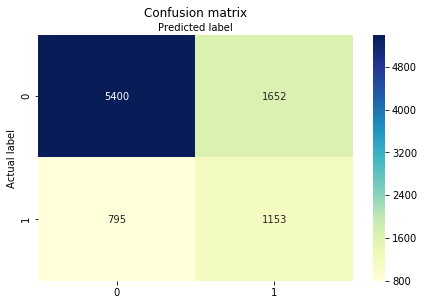

In [17]:
import numpy as np
from sklearn.model_selection import GridSearchCV

param_grid = {
    'ada__n_estimators': [1, 5, 10 , 23],
    'ada__learning_rate': np.linspace(0.1, 1, 4)
}

pipe = Pipeline([
    ('features', features),
    ('ada', AdaBoostClassifier())
])

clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1, scoring='recall')

clf.fit(X_train_resampled, y_train_resampled)

print(clf.best_params_)
y_hat_test = clf.predict(X_test)

print('======================')
print('Tested Model: ', 'ADABOOST')
print('======================')
print(classification_report(y_test, y_hat_test))
print_confusion_matrix(y_test, y_hat_test)
print('\n')

**Notes**: Also here we are not able to see any improvement after running an hyper-parameter tuning step. 
The best hyper-parameters found are the default ones in `AdaBoostClassifier` class.

## Conclusion

As seen above our best performing models to predict the target value (default credit payment status) are Logistoc Regression
model and AdaBoost model. We have also seen that dealing with imbalance dataset (using SMOTE) improved significantly our
models performances. 
Nonetheless, neither Logistoc Regression nor AdaBoost are great model predictors with an estimated recall score around .6 just 
above random guest. May be more features around individuals might help.
Another concllusion could also be that the unpredictable 